In [80]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import pickle
import array_to_latex as a2l
import markdown
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import pdfkit as pdf


import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.signal import savgol_filter


In [81]:
import sys
!{sys.executable} -m pip install Functions

In [82]:
# import sys
# !{sys.executable} -m pip install -U tslearn

In [83]:
data = pd.read_csv(
    "./markettrends0.csv",
    dtype={
        "state": "str",
        "sa3_name16": "str",
        "sa4_name16": "str",
        "postcode": "str",
        "state": "str",
        "property_type": "str",
    },
)
ndata = data.fillna(
    {"Volume of new rental listings (1 month)": 0, "Volume of sales (1 month)": 0}
).dropna(subset=["postcode"])
ndatahouses = ndata[:][ndata.property_type == "Houses"]
ndataunits = ndata[:][ndata.property_type == "Units"]

In [84]:
UniqueNames_sa4 = ndatahouses.sa4_name16.unique()[:-1]

In [85]:
# with open('DataFrameDict_postcode.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_postcode, f)
with open('DataFrameDict_postcode.pickle', 'rb') as f:
     DataFrameDict_postcode =  pickle.load(f)    

In [86]:
aveHPI_lv3 = []
lst = ["postcode", "sa4", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2020-01" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] =np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2020-01" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa4"] = DataFrameDict_postcode[key]["sa4_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year



In [87]:
def person_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .loc[DataFrameDict_HILDAp[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1]
            .loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1].loc[
            DataFrameDict_HILDAp[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1].loc[
            DataFrameDict_HILDA[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat(postcode, lst1, lst2):
    dfHILDA1 = house_cat(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num(postcode, lst1, lst2):
    dfHILDA1 = house_num(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
lst_age = [f'hgdob{i}' for i in range(1, 21)]

def HILDAext_age(postcode):    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age].loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage




In [88]:
import re
def nan_dum(df):
    df1_ohe = df
    nan_df = df1_ohe.loc[:, df1_ohe.columns.str.endswith("_nan")]
    pattern = "^([^_]*)_"
    regex = re.compile(pattern)
    for index in df1_ohe.index:
        for col_nan in nan_df.columns:
            if df1_ohe.loc[index, col_nan] == 1:
                col_id = regex.search(col_nan).group(1)
                targets = df1_ohe.columns[df1_ohe.columns.str.startswith(col_id + "_")]
                df1_ohe.loc[index, targets] = np.nan
    df1_ohe.drop(
        df1_ohe.columns[df1_ohe.columns.str.endswith("_nan")], axis=1, inplace=True
    )
    return df1_ohe

In [89]:
varnames_catp = ["ancob", "edhigh1", "anatsi", "chkb12", "sex"]
# varnames_nump = ["wsce", "baynoa"]
varnames_nump = ["wsce"]
varnames_cath = []
#varnames_cath = ["xpgroci"]
varnames_numh = ["hsdebt"]

# UniqueNames_Hsa4 = avg_3.sa4.unique()[:-1]
# DataFrameDict_Hsa4 = {elem: pd.DataFrame for elem in UniqueNames_Hsa4}

# for key in DataFrameDict_Hsa4.keys():
#     lstpcCL= ndatahouses['postcode'].loc[ndatahouses['sa4_name16'] == key].unique()
#     lst0 = list(set(lstpcCL) - set(HILDAallpc))
#     lstpc  = list(set(lstpcCL) - set(lst0))
#     df_tmp = pd.DataFrame([])
#     for key_pc in lstpc:
#         HILDAextract_num = HILDAext_num(key_pc, varnames_numh, varnames_nump)
#         HILDAextract_cat = HILDAext_cat(key_pc, varnames_cath, varnames_catp)
#         HILDAextract_age = HILDAext_age(key_pc)
#         HILDAextract = pd.merge(HILDAextract_num, HILDAextract_cat, on="date", how="left")
#         HILDAextract = pd.merge( HILDAextract , HILDAextract_age, on="date", how="left")
#         df_tmp = pd.concat([df_tmp, HILDAextract], axis=0, ignore_index=True)
#     dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=True)})
#     list1, list2 = zip(*dfHILDA.columns)
#     dfHILDA.columns = list1
#     DataFrameDict_Hsa4[key] = dfHILDA.reset_index()    

In [90]:
with open('DataFrameDict_Hsa4.pickle', 'rb') as f:
    DataFrameDict_Hsa4 =  pickle.load(f)

In [91]:
def HILDA2PCsa4(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa4PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa4[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [92]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)

In [93]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa4.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa4 = PCA(n_components=d2)
    pca_d_sa4.fit(X_train_std)
    X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa4PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
    pcadf_sa4_date = pcadf
    return  d2, pca_d_sa4

In [94]:
def person_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1].astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat_all(lst1, lst2):
    dfHILDA1 = house_cat_all( lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num_all( lst1, lst2):
    dfHILDA1 = house_num_all(lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
lst_age = [f'hgdob{i}' for i in range(1, 21)]
def HILDAext_age_all():    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage

In [95]:
# with open('dfHILDA_cut.pickle', 'wb') as f:
#     pickle.dump(dfHILDA_cut, f)
with open('dfHILDA_cut.pickle', 'rb') as f:
      dfHILDA_cut =  pickle.load(f)    

In [96]:
with open('dfHILDA.pickle', 'rb') as f:
      dfHILDA =  pickle.load(f)    

In [97]:
threshold = 0.01
df = dfHILDA_cut.set_index("date")
df1 = df.resample("Y").mean().iloc[:, :]
vrst = pd.DataFrame([])

# need a dataframe to writedown the way to stabilize all variables
df_marks = pd.DataFrame([],columns=['Variable Names', 'Approach'])


for vn in df1.columns.values[1:]:
    
    variable_tar = df1[vn]
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            new_row = {'Variable Names': vn,'Approach': suffix}
            df_marks = df_marks.append(new_row, ignore_index=True)
            newseries = pd.DataFrame(stationary_variable)
            vrst = pd.concat([vrst, newseries], axis=1)

    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

    
    
vrdata = vrst.reset_index()
    
pca = PCA()
X_train = vrdata.loc[:, vrdata.columns != "date"]
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.9) + 1
print(d2)

pca_d_sa4 = PCA(n_components=d2)
pca_d_sa4.fit(X_train_std)
X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

PCnames = []
for i in range(1, d2 + 1, 1):
    PCnames.append(f"sa4PC{i}")
    
pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa4_date = pcadf

6


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/2492502714.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_marks = df_marks.append(new_row, ignore_index=True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/2492502714.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_marks = df_marks.append(new_row, ignore_index=True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/2492502714.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_marks = df_marks.append(new_row, ignore_index=True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/2492502714.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [98]:
pcadf_sa4_date

,sa4PC1,sa4PC2,sa4PC3,sa4PC4,sa4PC5,sa4PC6,date
0,-3.550736,4.001405,-0.188887,0.702175,0.082950,0.705940,2001-06-30
1,-3.311801,3.042922,-0.298698,0.478824,-0.056509,0.621735,2002-06-30
2,-1.940258,1.558986,2.363045,-2.075545,1.574217,-0.968113,2003-06-30
3,-1.057147,0.898313,-0.442693,0.505976,-0.928006,-1.294751,2004-06-30
4,0.894035,0.283664,0.351091,2.571464,0.152391,0.574823,2005-06-30
5,-1.218458,-0.814166,0.832698,0.406326,-0.886287,-0.508086,2006-06-30
6,-0.920778,-1.816295,1.410426,0.311656,0.151475,-0.327882,2007-06-30
7,0.233330,-1.246341,0.581850,1.785910,-0.047347,-1.159676,2008-06-30
8,0.090411,-1.254053,1.929751,-0.327916,-0.638792,-0.175181,2009-06-30
9,-0.459637,-0.676281,1.395833,-0.284119,-1.173002,0.878372,2010-06-30


In [99]:
marks1 = df_marks['Variable Names'].loc[df_marks['Approach'] == 'original'].values
marks2 = df_marks['Variable Names'].loc[df_marks['Approach'] == "1storderdiff"].values
marks3 = df_marks['Variable Names'].loc[df_marks['Approach'] == "2ndorderdiff"].values
def selectStationaySeries3(variable_tar, vn, marks):
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    marks1 =marks['Variable Names'].loc[marks['Approach'] == 'original'].values
    marks2 =marks['Variable Names'].loc[marks['Approach'] == "1storderdiff"].values
    marks3 =marks['Variable Names'].loc[marks['Approach'] == "2ndorderdiff"].values
    
    if vn in marks1:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            #print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0 and vn in marks2:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0 and vn in marks3:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     

In [100]:
def HILDA2PCsa4(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa4PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa4[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [101]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)


In [102]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa4.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa4 = PCA(n_components=d2)
    pca_d_sa4.fit(X_train_std)
    X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa4PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
    pcadf_sa4_date = pcadf
    return  d2, pca_d_sa4

In [103]:
# PCnumbers = []
# x = range(0,100,1)
# for gamma in x:
#     gamma1 = gamma
#     d2, pcafit = PCA_val(gamma1,df_marks,vrdata)
#     PCnumbers.append(d2)
#     print(gamma)

In [104]:
x = range(0,100,1)
PCnumbers= [12, 12, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

(array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

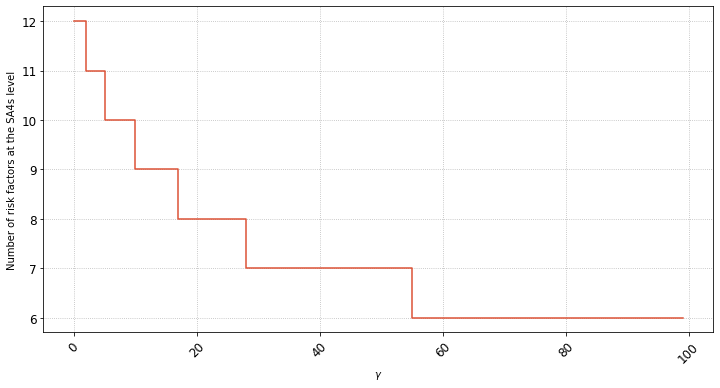

In [105]:
from scipy.interpolate import make_interp_spline, BSpline
# represents number of points to make between x.min and x.max
xnew =np.linspace(0, 100, 100)
spl = make_interp_spline(x, PCnumbers, k=1)  # type: BSpline
PCno_smooth = spl(xnew)

color1 = "#0085c3"
color2 = "#7ab800"
color3 = "#dc5034"

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.step(x, PCnumbers,where='post',color = color3)
ax.grid(ls=":", color="gray", alpha=0.6)

plt.xlabel(r'$\gamma$')
plt.ylabel('Number of risk factors at the SA4s level')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

In [106]:
gammaindexList = []
for i in range(12,6,-1):
   aa = min([index for index,value in enumerate(PCnumbers) if int(value)  == i])
   gammaindexList.append(aa)
gammaList = np.linspace(0, 100, 100)[gammaindexList]

In [107]:
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa4_date_new = pcadf


In [108]:
xls1 = pd.read_excel("f01hist.xls", sheet_name="Data", header=2)
xls1 = xls1.drop(xls1.index[0:8], axis=0)
xls1["Description"] = pd.to_datetime(xls1["Description"])
xls1["Description"] = xls1["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls3 = pd.read_excel("f11hist-1969-2009.xls", sheet_name="Data", header=2)
xls3 = xls3.drop(xls3.index[0:8], axis=0)
xls3["Description"] = pd.to_datetime(xls3["Description"])
xls3["Description"] = xls3["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls4 = pd.read_excel("f11hist.xls", sheet_name="Data", header=2)
xls4 = xls4.drop(xls4.index[0:8], axis=0)
xls4["Description"] = pd.to_datetime(xls4["Description"])
xls4["Description"] = xls4["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls34 = pd.concat([xls3, xls4], axis=0)
xls5 = pd.read_excel("g01hist.xls", sheet_name="Data", header=2)
xls5 = xls5.drop(xls5.index[0:8], axis=0)
xls5["Description"] = pd.to_datetime(xls5["Description"])
xls5["Description"] = xls5["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls6 = pd.read_excel("h01hist.xls", sheet_name="Data", header=2)
xls6 = xls6.drop(xls6.index[0:8], axis=0)
xls6["Description"] = pd.to_datetime(xls6["Description"])
xls6["Description"] = xls6["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls7 = pd.read_excel("h03hist.xls", sheet_name="Data", header=2)
xls7 = xls7.drop(xls7.index[0:8], axis=0)
xls7["Description"] = pd.to_datetime(xls7["Description"])
xls7["Description"] = xls7["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
# Download ASX data from Yahoo Finance

ASX200data = yf.download('^AXJO', start='1999-01-01', end='2021-06-01', interval = "1mo", progress=False)
ASX200data = ASX200data.reset_index()
ASX200data["Description"] = pd.to_datetime(ASX200data["Date"])
ASX200data["Description"] = ASX200data["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

macvar = pd.DataFrame().assign(
    Description=xls7.loc[
        ("2021-06" > xls7["Description"]) & (xls7["Description"] > "1998-12")
    ]["Description"]
)
macvar.reset_index(drop=True, inplace=True)

macvar = pd.merge(
    macvar,
    xls1[["Description", "Cash Rate Target; monthly average"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls34[["Description", "AUD/USD Exchange Rate; see notes for further detail."]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls5[["Description", "Consumer price index; All groups"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls6[["Description", "Gross domestic product (GDP); Chain volume"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Retail sales; All industries; Current price"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Private dwelling approvals"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    ASX200data[["Description", "Adj Close"]],
    on="Description",
    how="left",
)

macvar = macvar.set_axis(
    ["date", "ir", "exr", "cpi", "gdp", "rs", "pda", "asx"], axis=1, inplace=False
)


macvar["ir"] = macvar["ir"].astype(float, errors="raise")
macvar["exr"] = macvar["exr"].astype(float, errors="raise")
macvar["cpi"] = macvar["cpi"].astype(float, errors="raise")
macvar["gdp"] = macvar["gdp"].astype(float, errors="raise")
macvar["rs"] = macvar["rs"].astype(float, errors="raise")
macvar["pda"] = macvar["pda"].astype(float, errors="raise")
macvar["asx"] = macvar["asx"].astype(float, errors="raise")
macvar = macvar.interpolate()

threshold = 0.01

def selectStationaySeries(variable_tar):
        if adfuller(variable_tar.dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar
            suffix =  "original"
        elif adfuller(variable_tar.pct_change(1).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).dropna(how="all")
            suffix = "1storderdiff"
        elif adfuller(variable_tar.pct_change(3).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(3).dropna(how="all")
            suffix = "seasonaldiff"
        elif adfuller(variable_tar.pct_change(12).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(12).dropna(how="all")
            suffix = "annualdiff"     
        elif adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
            suffix = "2ndorderdiff"
        else:
            print("not found")
        return(pd.DataFrame(stationary_variable))
    
macvarst = macvar["date"] 
for vn in macvar.columns.values[1:]:
    macvarst = pd.concat([macvarst, selectStationaySeries(macvar[vn])], axis=1)

macvarsta = macvarst  
matrixmac = macvarsta.corr().round(2)
macdata = macvarsta.loc[
    ("2020-01" > macvarsta["date"]) & (macvarsta["date"] > "1999-12")
]

pca = PCA()
X_train = macdata.loc[:, macdata.columns != "date"]
poly= PolynomialFeatures(degree=2)
scaler = StandardScaler()

#X_train_poly = poly.fit_transform(X_train)
#X_train_std = scaler.fit_transform(X_train_poly)
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

pca_d = PCA(n_components=d)
pca_d.fit(X_train_std)
X_pca_d = pca_d.transform(X_train_std)
PCnames = []
for i in range(1, d + 1, 1):
    PCnames.append(f"PC{i}")
PC_nat = pd.DataFrame(X_pca_d, columns=PCnames)

PC_nat['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2000-01")].reset_index(drop= True)["date"]
PC_nat= PC_nat.set_index("date")

6


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/3122983395.py:84: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  macvar = macvar.set_axis(
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/3122983395.py:125: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrixmac = macvarsta.corr().round(2)


In [109]:
numcols = len(X_train_std[0])
numrows = len(X_train_std)
matrixones = np.ones((numrows, numcols))
matrixdiag = np.diag(np.diag(np.ones((numcols, numcols))))

In [110]:
pca_d.transform(matrixdiag)

array([[-0.30415021, -0.04406333,  0.65239764, -0.14823615,  0.67093812,
        -0.07877896],
       [-0.61450737,  0.18722406, -0.113981  ,  0.15501654, -0.06064396,
         0.67187603],
       [-0.04087253,  0.66140468,  0.29336408,  0.03947194, -0.32647867,
        -0.4136064 ],
       [-0.19796307, -0.36187347,  0.45490099, -0.44273536, -0.63532613,
         0.09614474],
       [-0.29220424, -0.59925711, -0.14666126,  0.30274108, -0.04291215,
        -0.43075913],
       [-0.12221443,  0.06607772, -0.44896844, -0.81189832,  0.17509797,
        -0.12736877],
       [-0.62345306,  0.17641333, -0.21285224,  0.07478132, -0.05861721,
        -0.40035757]])

In [111]:
avg_1_y = aveHPIdf_lv3.groupby(["year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1_y=avg_1_y.rename(columns = {'mean':'l0'})
avg_1_y['date'] = pd.to_datetime(avg_1_y['year'].apply(str)) + pd.offsets.YearEnd()
avg_1_y = avg_1_y.set_index("date")

avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1 = avg_1.set_index("date")
avg_1=avg_1.rename(columns = {'mean':'l0'})

avg_2 = aveHPIdf_lv3.groupby(["state","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2['date'] = pd.to_datetime(avg_2['year'].apply(str)) + pd.offsets.YearEnd()
avg_2 = avg_2.set_index("date")

avg_3 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3=avg_3.rename(columns = {'mean':'l01'})


avg_4 = aveHPIdf_lv3.groupby(["postcode","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_4=avg_4.rename(columns = {'mean':'l012'})


In [112]:
agg = avg_1.reset_index()
pcadf0 = PC_nat.reset_index()
pcadf = pcadf0.loc[("2020-01" > pcadf0["date"]) & (pcadf0["date"] > "2000-11")].reset_index(drop = True)


values  = agg["l0"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")].reset_index(drop=True).values
values = values.reshape((len(values), 1))

scaler1 = scaler.fit(values)
normalized  = scaler1.transform(values)
normalized_list =  [i[0] for i in normalized]
normalized_df = pd.DataFrame(normalized_list,columns = ['l0'])

pca_avg = pd.concat(
    [
        pcadf,
        normalized_df,
    ],
    axis=1,
)


df = pca_avg.iloc[:,1:]
model = VAR(df)
print(model.select_order(12).summary() )
# lag order should be one here

model_fitted = model.fit(1)
model_fitted.summary()
model_fitted_l0 =  model_fitted


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)


for col, val in zip(df.columns, out):
    print(col, ":", round(val, 2))

lag_order = model_fitted.k_ar
forecast_input = df
start_point = lag_order 

df_forecast = []
for i in range(1,df.shape[0]-lag_order+1, 1):
    forecast_input = df.values[
        -lag_order + start_point + i - 1 : start_point + i - 1,
    ]
    df_forecast.append(
        model_fitted.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )
    
values_forecast = np.array(df_forecast)
values_forecast = values_forecast.reshape((len(values_forecast), 1))
inversed = scaler1.inverse_transform(values_forecast)
inversed_list =  [i[0] for i in inversed]

lag_order_l0 = lag_order
start_point_l0 =  start_point
std_l0 = pca_avg.iloc[:,1:].std()

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -1.447      -1.339      0.2352      -1.404
1       -3.836     -2.967*     0.02158     -3.485*
2       -3.989      -2.359     0.01855      -3.331
3      -4.211*      -1.820    0.01491*      -3.245
4       -4.021     -0.8691     0.01814      -2.748
5       -3.879     0.03323     0.02112      -2.299
6       -3.962      0.7110     0.01973      -2.075
7       -3.837       1.597     0.02285      -1.642
8       -3.726       2.468     0.02627      -1.224
9       -3.745       3.210     0.02676     -0.9360
10      -3.597       4.119     0.03257     -0.4800
11      -3.526       4.951     0.03710     -0.1022
12      -3.432       5.806     0.04387      0.2996
--------------------------------------------------
PC1 : 2.02
PC2 : 2.01
PC3 : 2.22
PC4 : 2.05
PC5 : 2.07
PC6 : 2.0
l0 : 1.53


In [113]:
model_fitted_l0.coefs[0][-1][:-1]

array([-0.0720768 , -0.01011618, -0.02574083,  0.03347487, -0.04343205,
       -0.04924782])

In [114]:
model_fitted.test_causality('l0', ['PC1','PC2','PC3','PC4','PC5','PC6'], kind='f').summary()
# Results: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'] do Granger-cause l0.

Test statistic,Critical value,p-value,df
3.173,2.104,0.004,"(6, 1547)"


In [115]:
model_fitted.test_normality().summary()
# Results: data is not generated by normally-distributed process.

Test statistic,Critical value,p-value,df
404.8,23.68,0.000,14


In [116]:
#VARMA
# from statsmodels.tsa.statespace.varmax import VARMAX
# VARMA_model_l0  = VARMAX(pca_avg.iloc[:,1:],order = (1,0))
# VARMA_model_fit_l0 = VARMA_model_l0.fit(disp=False)
# VARMA_model_fit_l0.summary()

In [117]:
# a2l.to_ltx(VARMA_model_fit_l0.coefficient_matrices_var[0], frmt = '{:6.3f}')

In [118]:
# import numpy as np
# def create_upper_matrix(values, size):
#     upper = np.zeros((size, size))
#     upper[np.triu_indices(7, 0)] = values
#     return(upper)
# cov_l0 = create_upper_matrix(VARMA_model_fit_l0.params[-28:], 7)
# a2l.to_ltx(cov_l0, frmt = '{:6.3f}')

In [119]:
# irf_l0 = model_fitted_l0.irf(24)

In [120]:
# irf_l0.plot(response = 'l0', plot_params = {'ncols':3})

In [121]:
# irf_l0.plot_cum_effects(orth=False,figsize = (20,20))

In [122]:
df = pca_avg.iloc[:,1:]
nobs = 28  # post-covid data is used as the test data set
df_train, df_test = df[0:-nobs], df[-nobs:]
# Check size
start_point = df_train.shape[0]
lag_order = model_fitted_l0.k_ar
forecast_input = df_train.values[-lag_order:]

df_forecast = []
for i in range(1, nobs + 1, 1):
    forecast_input = df.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
    df_forecast.append(
        model_fitted_l0.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )
values_forecast = np.array(df_forecast)
values_forecast = values_forecast.reshape((len(values_forecast), 1))
inversed = scaler1.inverse_transform(values_forecast)
inversed_list =  [i[0] for i in inversed]
y = inversed_list



In [123]:
date_frame = pd.DataFrame(agg["date"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2001-01")].reset_index(drop=True))
x = date_frame[-nobs:]["date"]
df_plot = pd.DataFrame({'date':x, 'l0_pred':y })
y2 = agg["l0"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")].reset_index(drop=True)[-nobs:]
df_plot['l0'] = agg['l0'].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")][-nobs:].values
df_plot = df_plot.set_index('date',drop = True)

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_44206/771883143.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_plot['l0'] = agg['l0'].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")][-nobs:].values


In [124]:
avg_1_pred = pd.DataFrame(inversed_list, columns=["l0_forecast"])
avg_1_pred['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2001-01")].reset_index(drop= True)["date"]    
avg_1_pred  = avg_1_pred.set_index("date")


In [125]:
lst_whole = list(dfHILDA.columns)
result_ancob = [i for i in lst_whole if i.startswith('ancob_')]
list_ancob0 = ['1101', '2100', '1201', '7103', '5204', '6101', '9225', '5105', '2308']
list_ancob =  ['ancob_' + sub for sub in list_ancob0]
result_edhigh = [i for i in lst_whole if i.startswith('edhigh1_')]
list_edhigh0= ['1','2','3','4','5','8','9']
list_edhigh =  ['edhigh1_' + sub for sub in list_edhigh0]
result_anatsi = [i for i in lst_whole if i.startswith('anatsi_')]
list_anatsi0= ['1','2','3','4']
list_anatsi =  ['anatsi_' + sub for sub in list_anatsi0]
result_chkb =  [i for i in lst_whole if i.startswith('chkb12_')]
list_chkb0= ['1','2','3','4']
list_chkb =  ['chkb12_' + sub for sub in list_chkb0]
list_deleted =  [i for i in lst_whole if i.startswith(('ancob_','edhigh1_','chkb12_','anatsi_'))]
list_remained = [vn for vn in lst_whole if vn not in list_deleted]
list_final = list_remained + list_ancob + list_edhigh + list_anatsi + list_chkb

In [126]:
def gamma2AIC_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)

    modelsa4 = VAR(pcadf_sa4_date_new)
    result = modelsa4.fit(lag)
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(result.aic)

In [127]:
def gamma2BIC_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)

    modelsa4 = VAR(pcadf_sa4_date_new)
    result = modelsa4.fit(lag)
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(result.bic)

In [128]:
def gamma2FPE_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)

    modelsa4 = VAR(pcadf_sa4_date_new)
    result = modelsa4.fit(lag)
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(result.fpe)


In [129]:
def gamma2HQIC_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)

    modelsa4 = VAR(pcadf_sa4_date_new)
    result = modelsa4.fit(lag)
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(result.hqic)

In [130]:
def gamma2pre_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]

    modelsa4 = VAR(df)
    model_fitted = modelsa4.fit(lag)
    
    lag_order = model_fitted.k_ar
    forecast_input = df
    start_point = lag_order 

    df_forecast = []
    for i in range(1,df.shape[0]-lag_order+1, 1):
        forecast_input = df.values[
            -lag_order + start_point + i - 1 : start_point + i - 1,
        ]
        df_forecast.append(
            model_fitted.forecast(y=forecast_input, steps=1)[
                0,
            ][-1]
        )
    avg_3_pred_sa4 = pd.DataFrame(df_forecast, columns=["l1_forecast"])
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(avg_3_pred_sa4)

In [131]:
def gamma2rf(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(pcadf)

In [132]:
gammaList[2]

5.050505050505051

In [133]:
import statsmodels.api as statm
from statistics import mean
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
gamma_final = gammaList[2]
d3_final, pcafit_final = PCA_val(gamma_final,df_marks,vrdata)
lag_final = 1

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in 

In [134]:
avg_3_pred_values= []
lst = ["date","sa4", "l0_fc", "l1_fc", "l01_fc"]
# Calling DataFrame constructor on list
for key in DataFrameDict_Hsa4.keys():    
    try:
        df = pd.DataFrame([], columns=lst)
        df1 = avg_1_pred.reset_index()
        df["date"] = df1["date"].loc[("2020-01" >df1["date"])& (df1["date"] > "1999-12")]
        df["sa4"] = key 
        df["l0_fc"] = df1["l0_forecast"].loc[("2020-01" >df1["date"])& (df1["date"] > "1999-12")]
        df["l1_fc"] = gamma2pre_VAR(key, pcafit_final, d3_final, lag_final)["l1_forecast"]
        df["l01_fc"]  = df["l0_fc"] + df["l1_fc"]
        avg_3_pred_values.append(df)
        
    except:
        pass

avg_3_pred = pd.concat(avg_3_pred_values)
avg_3_pred = avg_3_pred.reset_index(drop=True)
avg_3_pred['date'] = pd.to_datetime(avg_3_pred['date'],errors = 'coerce')
    

In [135]:
avg_3_pred = avg_3_pred.drop(['l0_fc', 'l1_fc'], axis=1)    

In [159]:
Rsq = []
MSE = []
postcode_list_OLS = []
sa4_list_OLS = []
for key in DataFrameDict_postcode.keys():
    try:
        df = pd.DataFrame([])
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] == sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        #result = statm.OLS(y, X).fit()
        result = statm.OLS(y, X).fit()
        Rsq.append(result.rsquared)
        MSE.append(result.mse_total)
        sa4_list_OLS.append(sa4_name)
        postcode_list_OLS.append(key)
        
    except:
        print(key)
        print(sa4_name)
        pass
        
cleanedRsq = [x for x in Rsq if str(x) != "nan"]
mean(cleanedRsq)   


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


4670
Wide Bay
4655
Wide Bay
4650
Wide Bay
4615
Wide Bay


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


0.11998853082572587

In [163]:
cleanedMSE = [x for x in MSE if str(x) != "nan"]
mean(cleanedMSE)**(1/2)   

0.016594842273953272

In [142]:
avg_4

,postcode,date,l012
0,0810,1999-12-31,NaN
1,0810,2000-01-31,0.020189
2,0810,2000-02-29,0.002960
3,0810,2000-03-31,0.004537
4,0810,2000-04-30,-0.034695
...,...,...,...
111819,7321,2019-08-31,-0.021176
111820,7321,2019-09-30,-0.005944
111821,7321,2019-10-31,0.052299
111822,7321,2019-11-30,0.025115


In [143]:
# from pathlib import Path  

In [172]:
# filepath = Path('observations.csv')  
observation = avg_4.pivot(index='date',columns='postcode',values = 'l012')[1:]
# observation.to_csv(filepath)

In [140]:
# filepath = Path('knownvariables.csv')  
# PC_nat.to_csv(index = False)
# PC_nat.to_csv(filepath)

In [153]:
RF_FAVAR = pd.read_csv("./RF_FAVAR.csv").iloc[:,1:]

In [157]:

model_FAVAR = VAR(RF_FAVAR)

x = model_FAVAR.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,21.50,21.74,2.166e+09,21.59
1,12.00,16.09*,1.638e+05,13.65*
2,12.00,19.94,1.677e+05,15.20
3,11.84,23.64,1.551e+05*,16.60
4,12.31,27.95,2.873e+05,18.62
5,12.35,31.84,3.880e+05,20.22
6,11.96,35.31,3.953e+05,21.38
7,11.83,39.02,6.335e+05,22.80
8,11.25,42.30,8.659e+05,23.78
9,10.24,45.14,1.126e+06,24.32


In [169]:
fitted_FARVA= pd.read_csv("./fitted_FARVA.csv")

In [170]:
fitted_FARVA

,X0810,X0820,X0870,X2010,X2018,X2026,X2030,X2031,X2035,X2037,...,X7116,X7140,X7248,X7249,X7250,X7300,X7304,X7310,X7320,X7321
0,0.021228,0.013556,0.036559,0.001026,0.003353,-0.000591,-0.005746,0.009134,0.010990,0.001758,...,0.011092,0.005424,-0.022995,-0.025949,-0.016893,0.020883,0.001235,-0.003217,-0.013930,-0.008985
1,-0.000383,0.031949,0.019518,-0.008655,-0.008000,0.001709,0.004373,0.008000,0.008900,-0.005546,...,0.015777,0.014105,0.017530,0.011244,0.009738,0.028912,-0.003544,0.019986,0.027695,0.028455
2,-0.001023,0.012515,-0.003953,-0.000493,0.006958,0.004353,0.004633,0.016838,0.017174,-0.003516,...,0.016969,0.020197,0.013501,0.008381,0.005770,0.002729,-0.012807,0.025704,0.021281,0.044162
3,0.004265,-0.007280,-0.003205,0.007771,0.007987,-0.011809,-0.010761,-0.007455,-0.000312,0.008115,...,0.001359,0.014614,0.011480,0.008810,0.013162,0.010342,0.008229,0.002869,-0.004827,0.004643
4,0.005408,-0.001789,-0.007804,0.000418,0.004051,-0.011559,-0.014706,-0.009949,-0.007980,0.002838,...,0.030277,0.048328,0.008144,0.000537,0.008505,0.009038,0.003255,0.034098,0.020385,0.040992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,-0.018479,-0.014374,-0.015421,0.034045,0.026843,0.036143,0.037095,0.017473,0.018393,0.036618,...,0.007557,0.001407,0.005277,0.011339,0.007484,-0.009765,-0.001700,-0.013143,0.001006,-0.020575
236,-0.008620,-0.001311,0.006241,0.032927,0.033524,0.039911,0.036562,0.029807,0.030194,0.038942,...,0.008340,0.006191,0.004586,0.008110,0.002146,0.004007,0.004195,-0.007485,0.003344,-0.002371
237,0.004832,-0.001245,0.014846,0.035174,0.043413,0.036854,0.027959,0.045936,0.043614,0.039236,...,0.003183,0.008448,-0.001946,-0.000652,-0.006419,0.001780,0.003278,0.001601,-0.003039,0.013329
238,-0.013320,-0.004860,-0.012846,0.050336,0.047015,0.061554,0.063140,0.036978,0.041518,0.054481,...,0.022790,0.015203,0.011533,0.016223,0.015565,-0.002421,0.008075,-0.004778,0.010331,-0.001735


In [173]:
observation

postcode,0810,0820,0870,2010,2018,2026,2030,2031,2035,2037,...,7116,7140,7248,7249,7250,7300,7304,7310,7320,7321
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.020189,-0.020570,0.005168,-0.002303,-0.007156,0.006487,0.002827,0.005375,0.005856,-0.020047,...,0.031232,0.025301,-0.043766,-0.050148,-0.019182,0.056390,-0.008168,0.012710,0.043669,0.000273
2000-02-29,0.002960,0.059627,0.031578,0.027258,0.009419,-0.007930,-0.018756,0.014057,0.029034,-0.005590,...,0.047395,0.008250,0.019142,-0.010766,-0.005046,0.058459,-0.058029,-0.041234,0.009367,0.020141
2000-03-31,0.004537,0.006877,0.014223,-0.001159,0.010475,0.027292,0.047378,0.019209,0.035829,-0.005227,...,0.017839,0.039976,0.038391,0.017078,0.006406,-0.008055,0.012144,0.027340,0.013773,0.108010
2000-04-30,-0.034695,-0.022285,-0.053188,0.018882,0.013574,0.006972,0.024476,-0.003070,-0.011066,0.019113,...,0.055877,0.011292,0.003829,0.009853,0.010914,0.031640,0.029443,-0.012335,0.009415,-0.023166
2000-05-31,0.014369,-0.018193,0.003652,0.003586,-0.009754,-0.025243,-0.007891,-0.007005,-0.019157,0.020838,...,0.008497,0.030387,-0.024592,-0.036001,0.005832,-0.072755,0.019835,0.042236,-0.041787,0.006769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-0.062650,-0.030905,0.016077,0.042753,0.023378,0.083852,0.065679,-0.027588,-0.023130,0.045988,...,-0.015750,0.036376,0.018488,0.016907,0.007547,0.001235,0.023396,-0.013050,-0.015779,-0.021176
2019-09-30,-0.006093,0.020964,-0.003420,0.012014,0.018949,0.017984,0.012397,0.059275,0.042494,0.018811,...,0.010972,-0.030421,0.014697,0.008799,0.006956,0.013339,0.010003,-0.007663,0.013438,-0.005944
2019-10-31,-0.000837,0.003963,-0.016764,0.041428,0.043548,-0.017992,-0.030913,0.029699,0.030041,0.031836,...,0.001681,0.021872,0.011599,0.012541,0.005214,-0.031703,0.014111,-0.004089,-0.001221,0.052299
